The binomial options pricing model (BOPM) provides a generalizable numerical method for the valuation of options. Essentially, the model uses a "discrete-time" (lattice based) model of the varying price over time of the underlying financial instrument.

https://en.wikipedia.org/wiki/Binomial_options_pricing_model

# Vanilla european call and put options evaluation using the Binomial Tree Model

Main assumptions:

- Simple two-state economy
- Interest rate is constant
- No dividend payments
- Arbitrage-free economy
- No transaction cost

The lattice is generated using the original Cox, Ross, & Rubinstein (CRR) method

In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats

In [2]:
# Option parameters

T = 1 # time at maturity, e.g. one year
N = 50 # amount of steps
sigma = .2 # sigma is the volatility of the stock(std)
r = .06 # interest rate (risk-free assumtion)
S0 = 100 # current price of the stock
K = 99 # strike price

In [3]:
def binomial_tree(T, N, sigma, r, S0, K, is_call=True):
    """
    Approximates the option price for the given amount of steps
    using backward induction scheme and returns the value at the first node
    """
    
    # time discretization
    dt = T / N
    
    # using formulas for up and down movements
    u = math.exp(sigma * math.sqrt(dt)) 
    d = math.exp(-sigma * math.sqrt(dt))
    
    # price approximation for each step
    p = (math.exp(r * dt) - d) / (u - d)
    
    # calculate the value of the stock price for the expiration day nodes
    final_nodes_stock = []

    for i in range(0, N + 1):
        final_nodes_stock.append(S0 * math.pow(u, N - i) * math.pow(d, i))

    # calculate the value of the option for the expiration day nodes
    final_nodes_option = []

    if is_call:
        for i in range(0, N + 1):
            final_nodes_option.append(max(0, final_nodes_stock[i] - K))
    else:
        for i in range(0, N + 1):
            final_nodes_option.append(max(0, K - final_nodes_stock[i]))


    # loop backwards through all nodes and calculate option values
    for i in range(N, 0, -1):    
        binomial_tree = []
        for j in range(0, i):
            binomial_tree.append(
                math.exp(-r * dt) * (final_nodes_option[j] * p + (1 - p) * 
                                     final_nodes_option[j + 1]))
        final_nodes_option = binomial_tree

    return binomial_tree

With the specified parameters we get

In [5]:
print('call: ' + str(binomial_tree(T, N, sigma, r, S0, K)) + 
      '\nput: ' + 
      str(binomial_tree(T, N, sigma, r, S0, K, is_call=False)))

call: [11.546434850755071]
put: [4.7811236755959206]


Model's convergence on the theoretical value of the Black-Scholes equation. The convergence is of course the same for call and put options.

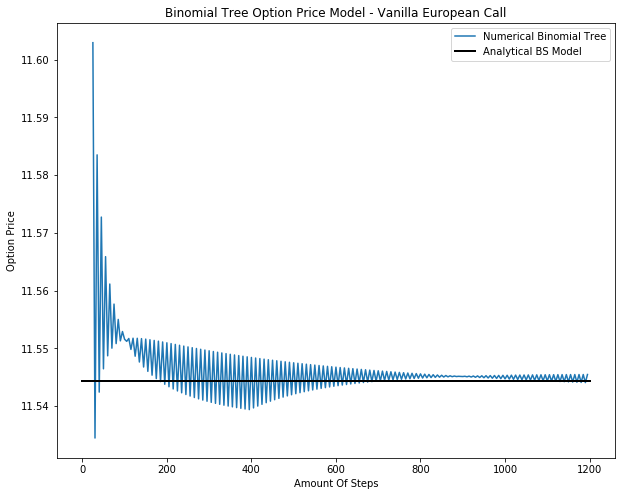

In [6]:
option_prices = []
steps =[]

for n in range(25, 1200, 5):
    option_prices.append(binomial_tree(1, n, .2, .06, 100, 99))
    steps.append(n)
    
plt.figure(figsize=(10, 8))
plt.plot(steps, option_prices, label = 'Numerical Binomial Tree')
plt.plot([0, 1200], [11.5443, 11.5443], color = 'k', linestyle = '-', 
         linewidth = 2, label = 'Analytical BS Model')
plt.legend(loc = 'upper right')
plt.ylabel('Option Price')
plt.xlabel('Amount Of Steps')
plt.title('Binomial Tree Option Price Model - Vanilla European Call')
plt.show()

## Computing the hedge parameter from the Binomial Tree Option Price Model. Experimenting for different values of the volatility.

In [7]:
def get_params(sigma):
    """
    This function returns parameters for our calculations,
    sigma is the standard deviation of the stock price - the volatility of the stock
    """
    T = 1 # time maturity
    N = 50 # amount of steps
    r = .06 # interest rate
    S0 = 100 # initial stock price
    K = 99 # strike price at maturity
        
    dt = T / N # time discretization

    u = math.exp(sigma * math.sqrt(dt)) #up movement formula
    d = math.exp(-sigma * math.sqrt(dt)) #down movement formula

    p = (math.exp(r * dt) - d)/(u - d) # price approximation
    
    params = {
        'T': T,
        'N': N,
        'sigma': sigma,
        'r': r,
        'dt': dt,
        'u': u,
        'd': d,
        'S0': S0,
        'K': K,
        'p': p
    }
    
    return params

In [8]:
def get_hedge(params):
    """
    Finds the hedge parameter for a vanilla european call option at each node
    and returns the hedge parameter at the first node.
    """
    end_nodes_stock = []
    end_nodes_option = []

    for n in range(0, params['N'] + 1):
        end_nodes_stock.append(
            params['S0'] * math.pow(params['u'], params['N'] -
                                    (n)) * math.pow(params['d'], (n)))
        end_nodes_option.append(max(0, end_nodes_stock[n] - params['K']))

    for i in range(params['N'], 0, -1):
        previous_nodes_stock = []
        previous_nodes_option = []
        hedge = 0
        for j in range(0, i):
            previous_nodes_stock.append(
                math.exp(-params['r'] * params['dt']) *
                (end_nodes_stock[j] * params['p'] +
                 (1 - params['p']) * end_nodes_stock[j + 1]))
            previous_nodes_option.append(
                math.exp(-params['r'] * params['dt']) *
                (end_nodes_option[j] * params['p'] +
                 (1 - params['p']) * end_nodes_option[j + 1]))
            hedge = (end_nodes_option[j] - end_nodes_option[j + 1]) / (
                end_nodes_stock[j] - end_nodes_stock[j + 1])
        end_nodes_stock = previous_nodes_stock
        end_nodes_option = previous_nodes_option

    return hedge

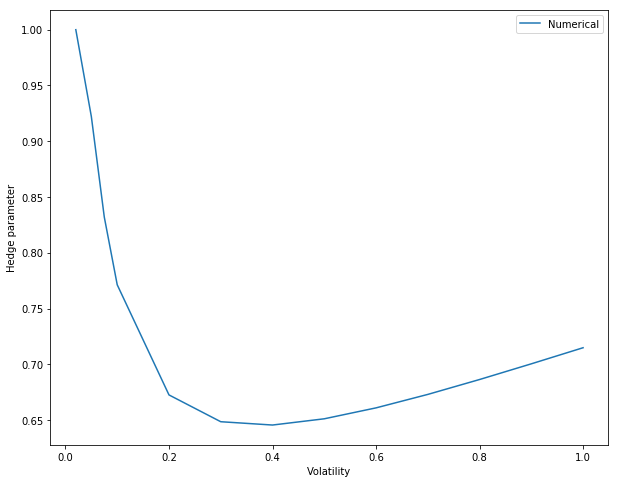

In [9]:
sigma_values = [.02, .05, .075, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.]
hedge_values = []

for sigma in sigma_values:
    hedge_values.append(get_hedge(get_params(sigma)))

plt.figure(figsize=(10, 8))
plt.plot(sigma_values, hedge_values, label='Numerical')
plt.xlabel('Volatility')
plt.ylabel('Hedge parameter')
plt.legend()
plt.show()